In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

In [2]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df_x = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 0, usecols = [1,2,3,4])
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
print(len(df_x))
df_x.head()

24


,Buffer_Type,pH,Sugar_Salt,Additive
0,Ace,4.5,4% Sorbitol,Arginine
1,Ace,4.5,4% Sorbitol,Glycine
2,Ace,5.0,4% Sorbitol,Arginine
3,Ace,5.0,4% Sorbitol,Glycine
4,Ace,5.0,0.1M NaCl,Glycine


In [3]:
df_y_1 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [1,4,7],skiprows = lambda x: x in [1])
df_y_1.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_y_1.columns]
print(len(df_y_1))
print(df_y_1.head())

df_y_2 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [2,5,8],skiprows = lambda x: x in [1])
df_y_2.columns = df_y_1.columns
print(len(df_y_2))
print(df_y_2.head())

df_y_3 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [3,6,9],skiprows = lambda x: x in [1])
df_y_3.columns = df_y_1.columns
print(len(df_y_3))
print(df_y_3.head())

24
   _Dimer_HMW_  _Monomer  _LMW
0          2.4      95.1   2.5
1          0.8      97.3   2.0
2          3.2      94.3   2.6
3          1.4      96.7   1.9
4          4.2      93.3   2.5
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.6      96.2   2.2
1          1.1      96.6   2.2
2          2.0      95.6   2.4
3          1.4      96.4   2.3
4          2.3      95.2   2.4
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.8      93.8   4.4
1          0.7      95.1   4.2
2          2.7      93.4   3.9
3          1.3      95.0   3.6
4          3.4      92.7   4.0


In [4]:
cols_feature01 = list(df_x.columns)
cols_target = list(df_y_1.columns)[0:2]
#cols_target = ['UP_SEC_HMW','UP_SEC_LMW']
cols_cate = ['Buffer_Type',
 'Sugar_Salt',
 'Additive']

In [5]:
total_df_y_long = pd.concat((df_y_1[cols_target],df_y_2[cols_target],df_y_3[cols_target]),axis = 0)
total_df_y_long.reset_index(inplace = True, drop = True)
total_df_y_long

,_Dimer_HMW_,_Monomer
0,2.4,95.1
1,0.8,97.3
2,3.2,94.3
3,1.4,96.7
4,4.2,93.3
...,...,...
67,3.3,92.3
68,3.7,92.3
69,3.6,92.2
70,4.2,90.8


In [6]:
df_y_1.columns = [c+'_1' for c in df_y_1.columns]
df_y_2.columns = [c+'_2' for c in df_y_2.columns]
df_y_3.columns = [c+'_3' for c in df_y_3.columns]

In [7]:
total_df_y = pd.concat((df_y_1[['_Dimer_HMW__1','_Monomer_1']],
                        df_y_2[['_Dimer_HMW__2','_Monomer_2']],
                        df_y_3[['_Dimer_HMW__3','_Monomer_3']]),axis = 1)

display(total_df_y.head())
"""
#convert categorical columns to labels
for x_name in cols_cate:
    labels, categories = factorize(df_x[x_name])
    df_x[x_name+"_label"] = labels
df_x.drop(cols_cate,axis = 1,inplace = True)

display(df_x.head())
"""

,_Dimer_HMW__1,_Monomer_1,_Dimer_HMW__2,_Monomer_2,_Dimer_HMW__3,_Monomer_3
0,2.4,95.1,1.6,96.2,1.8,93.8
1,0.8,97.3,1.1,96.6,0.7,95.1
2,3.2,94.3,2.0,95.6,2.7,93.4
3,1.4,96.7,1.4,96.4,1.3,95.0
4,4.2,93.3,2.3,95.2,3.4,92.7


'\n#convert categorical columns to labels\nfor x_name in cols_cate:\n    labels, categories = factorize(df_x[x_name])\n    df_x[x_name+"_label"] = labels\ndf_x.drop(cols_cate,axis = 1,inplace = True)\n\ndisplay(df_x.head())\n'

In [8]:
#onehot encoding
df_x = pd.get_dummies(df_x, columns = cols_cate)
#print(total_df.head())
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
#df_x.drop(cols_cate,axis = 1,inplace = True)
#convert boolean True False to 0 1
bool_cols = df_x.select_dtypes(include='bool').columns
df_x[bool_cols] = df_x[bool_cols].astype(int)
print(df_x.head())

    pH  Buffer_Type_Ace  Buffer_Type_Cit  Buffer_Type_His  Buffer_Type_Phos  \
0  4.5                1                0                0                 0   
1  4.5                1                0                0                 0   
2  5.0                1                0                0                 0   
3  5.0                1                0                0                 0   
4  5.0                1                0                0                 0   

   Sugar_Salt_0_1M_NaCl  Sugar_Salt_4_Sorbitol  Additive_Arginine  \
0                     0                      1                  1   
1                     0                      1                  0   
2                     0                      1                  1   
3                     0                      1                  0   
4                     1                      0                  0   

   Additive_Glycine  
0                 0  
1                 1  
2                 0  
3                 1  


In [14]:
new_total_df_y = total_df_y[['_Dimer_HMW__1','_Dimer_HMW__2','_Dimer_HMW__3',
                             '_Monomer_1','_Monomer_2','_Monomer_3']]
new_total_df_y.to_csv('data/harpoon_total_df_y.csv')

In [12]:
df_x.to_csv('data/harpoon_df_x.csv')

##DPS dataset

In [15]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_csv('data/dps-cleaned-missing.csv')
print(len(df))
df.head()

1843


,Import_Date,ISID,Project,Protein,Modality,Control_Type,Stress_Condition,Temp_C_,Time_Days_,Well_ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified_Excipients,1st_Excipient_in_Sample,2nd_Excipient_in_Sample,_Conc_for_Excipient1,Origin_of_data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [16]:
cols_group = ['Project','Protein','Modality', 'Stress_Condition','Temp_C_', 'Time_Days_']
cols_feature01 = ['Buffer','NaCl_mM_', 'pH']
cols_feature02 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']
#cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']
cols_target = ['UP_SEC_Monomer','UP_SEC_LMW']
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


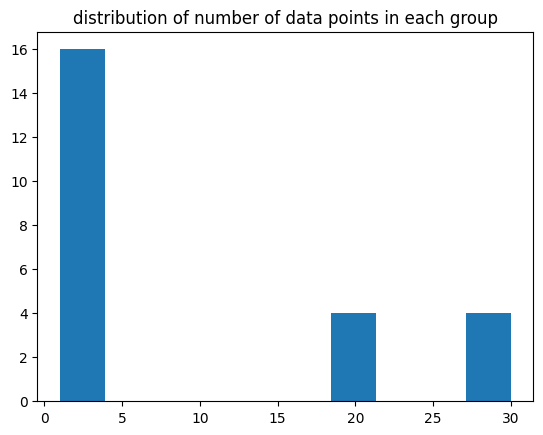

In [17]:
# split dataframe by identifiers
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits_identifier = list(df[cols_group + cols_feature01+cols_target].groupby(cols_group,dropna=is_drop_na))
#splits_identifier = list(df[cols_group + cols_cate+['pH']+cols_target].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits_identifier]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [39]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)


print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))

split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
#split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
#split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
#split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]


True
True


In [40]:
#input space 8==9==11 != 10
split8 = splits_identifier[8]
split9 = splits_identifier[9]
split10 = splits_identifier[10]
split11 = splits_identifier[11]

split8_formulation_df = split8[1][cols_feature01]
split8_formulation_df.reset_index(drop = True,inplace =True)
split9_formulation_df = split9[1][cols_feature01]
split9_formulation_df.reset_index(drop = True,inplace =True)
split10_formulation_df = split10[1][cols_feature01]
split10_formulation_df.reset_index(drop = True,inplace =True)
split11_formulation_df = split11[1][cols_feature01]
split11_formulation_df.reset_index(drop = True,inplace =True)

print('----does 8 equal 9---')
print(split8_formulation_df.equals(split9_formulation_df)) 
print('----does 8 equal 10---')
print(split8_formulation_df.equals(split10_formulation_df))
print('----does 8 equal 11---')
print(split8_formulation_df.equals(split11_formulation_df))
print('----does 9 equal 10---')
print(split9_formulation_df.equals(split10_formulation_df))
print('----does 9 equal 11---')
print(split9_formulation_df.equals(split11_formulation_df))
print('----does 10 equal 11---')
print(split10_formulation_df.equals(split11_formulation_df))#! split 10 has a different input than 8,9,11

split8_target_df = split8[1][cols_target]
split8_target_df.reset_index(drop = True,inplace =True)
#split8_target_df.columns = [c+'_8' for c in split8_target_df.columns]

split9_target_df = split9[1][cols_target]
split9_target_df.reset_index(drop = True,inplace =True)
#split9_target_df.columns = [c+'_9' for c in split9_target_df.columns]

split10_target_df = split10[1][cols_target]
split10_target_df.reset_index(drop = True,inplace =True)
#split10_target_df.columns = [c+'_10' for c in split10_target_df.columns]

split11_target_df = split11[1][cols_target]
split11_target_df.reset_index(drop = True,inplace =True)
#split11_target_df.columns = [c+'_11' for c in split11_target_df.columns]

----does 8 equal 9---
True
----does 8 equal 10---
False
----does 8 equal 11---
True
----does 9 equal 10---
False
----does 9 equal 11---
True
----does 10 equal 11---
False


In [20]:
def remove_col_outlier(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    keep_inds = ~((df[col] < (Q1 - 2 * IQR)) |(df[col] > (Q3 + 2 * IQR)))
    df = df[keep_inds]
    return df,keep_inds

In [41]:
"""
split1_target_df,keep1_inds = remove_col_outlier(split1_target_df,cols_target[1])
split3_target_df,keep3_inds = remove_col_outlier(split3_target_df,cols_target[1])
split5_target_df,keep5_inds = remove_col_outlier(split5_target_df,cols_target[1])

split1_formulation_df = split1_formulation_df[(keep1_inds)]
split3_formulation_df = split3_formulation_df[(keep3_inds)]
split5_formulation_df = split5_formulation_df[(keep5_inds)]

print(split1_formulation_df.shape)
print(split3_formulation_df.shape)
print(split5_formulation_df.shape)

split8_target_df,keep8_inds = remove_col_outlier(split8_target_df,cols_target[1])
split9_target_df,keep9_inds = remove_col_outlier(split9_target_df,cols_target[1])
split10_target_df,keep10_inds = remove_col_outlier(split10_target_df,cols_target[1])
split11_target_df,keep11_inds = remove_col_outlier(split11_target_df,cols_target[1])


split8_formulation_df = split8_formulation_df[(keep8_inds)]
split9_formulation_df = split9_formulation_df[(keep9_inds)]
split10_formulation_df = split10_formulation_df[(keep10_inds)]
split11_formulation_df = split11_formulation_df[(keep11_inds)]

"""
print(split8_formulation_df.shape)
print(split9_formulation_df.shape)
print(split10_formulation_df.shape)
print(split11_formulation_df.shape)



(30, 3)
(30, 3)
(30, 3)
(30, 3)


In [42]:
#convert Buffer column to labels
x_name = 'Buffer'
labels, categories = factorize(split8_formulation_df[x_name])
split8_formulation_df[x_name+"_label"] = labels
split8_formulation_df.drop(x_name,inplace = True, axis = 1)

labels, categories = factorize(split9_formulation_df[x_name])
split9_formulation_df[x_name+"_label"] = labels
split9_formulation_df.drop(x_name,inplace = True, axis = 1)

labels, categories = factorize(split10_formulation_df[x_name])
split10_formulation_df[x_name+"_label"] = labels
split10_formulation_df.drop(x_name,inplace = True, axis = 1)

labels, categories = factorize(split11_formulation_df[x_name])
split11_formulation_df[x_name+"_label"] = labels
split11_formulation_df.drop(x_name,inplace = True, axis = 1)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_43561/591736437.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split8_formulation_df[x_name+"_label"] = labels
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_43561/591736437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split8_formulation_df.drop(x_name,inplace = True, axis = 1)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_43561/591736437.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [43]:
split8_formulation_arr = split8_formulation_df.to_numpy()
split9_formulation_arr = split9_formulation_df.to_numpy()
split10_formulation_arr = split10_formulation_df.to_numpy()
split11_formulation_arr = split11_formulation_df.to_numpy()

In [58]:
X_list = []
n_datapoints = split8_formulation_arr.shape[0]
replicates = np.array([1.,1.,1.,1.,2.,2.,2.,2.]) #two outputs, three replicates
X1 = replicates.reshape(-1,1)-1
for i in range(n_datapoints):
    X0 = np.vstack((split8_formulation_arr[i],
                    split9_formulation_arr[i],
                    split10_formulation_arr[i],
                    split11_formulation_arr[i]
                    ))
    X0 = np.vstack((X0,X0))
    X_list.append(np.hstack((X0,X1)))

In [59]:
X_list[3]

array([[0. , 6.2, 0. , 0. ],
       [0. , 6.2, 0. , 0. ],
       [0. , 5. , 1. , 0. ],
       [0. , 6.2, 0. , 0. ],
       [0. , 6.2, 0. , 1. ],
       [0. , 6.2, 0. , 1. ],
       [0. , 5. , 1. , 1. ],
       [0. , 6.2, 0. , 1. ]])

In [54]:
split8_target_arr = split8_target_df.to_numpy()
split9_target_arr = split9_target_df.to_numpy()
split10_target_arr = split10_target_df.to_numpy()
split11_target_arr = split11_target_df.to_numpy()

In [60]:
Y_list = []
for i in range(n_datapoints):
    Y0 = np.vstack((split8_target_arr[i,0],
                    split9_target_arr[i,0],
                    split10_target_arr[i,0],
                    split11_target_arr[i,0]
                    ))
    Y1 = np.vstack((split8_target_arr[i,1],
                    split9_target_arr[i,1],
                    split10_target_arr[i,1],
                    split11_target_arr[i,1]
                    ))
    Y = np.vstack((Y0,Y1))
    Y_list.append(Y)
Y_list[0]

array([[90.71],
       [90.94],
       [89.57],
       [89.51],
       [ 9.29],
       [ 9.06],
       [10.43],
       [10.49]])